# Othello

In this notebook, we'll design and implement an AI capable of playing the classic board game Othello (also known as Reversi). We'll leverage techniques from game theory and search algorithms to create an intelligent agent that can play strategically and competitively.

Following our exploration of pathfinding in deterministic environments and stochastic decision making, we now turn to adversarial scenarios where we need to consider an opponent's moves.

Othello provides an excellent environment for studying adversarial search algorithms:

- It has clear, deterministic rules
- The game state is fully observable
- Players take turns making moves
- The branching factor (number of possible moves) is manageable

## Game Rules

Othello is played on an 8x8 board with two players: black and white. The game starts with two black and two white pieces placed in the center of the board (the two black pieces are diagonally adjacent to each other, and the same for the two white pieces). Players take turns placing their pieces on the board, with the goal of capturing their opponent's pieces by surrounding them. A player can capture one or more of their opponent's pieces by placing their piece in a position that creates a straight line (horizontal, vertical, or diagonal) between two of their own pieces. The game ends when neither player can make a valid move, and the player with the most pieces on the board wins.

## Environment Setup

To get started, we need to set up the Othello environment. We'll create a class to represent the game board, manage the game state, and implement the rules of Othello. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Circle
from IPython.display import clear_output
from random import randint
import time

class OthelloGame:
    # Game constants
    SIZE = 8
    BLACK = 1
    WHITE = -1
    EMPTY = 0
    PASS_MOVE = SIZE * SIZE
    
    # Directions (clockwise from right): right, up-right, up, up-left, left, down-left, down, down-right
    DIRECTIONS = (1, 1 - SIZE, -SIZE, -1 - SIZE, -1, -1 + SIZE, SIZE, 1 + SIZE)
    
    def __init__(self):
        # Initialize board
        self.board = np.zeros(self.SIZE * self.SIZE, dtype=int)
        
        # Set up initial position
        self.board[3 * self.SIZE + 3] = self.WHITE
        self.board[4 * self.SIZE + 4] = self.WHITE
        self.board[3 * self.SIZE + 4] = self.BLACK
        self.board[4 * self.SIZE + 3] = self.BLACK
        
        # Precompute limits for each position and direction to prevent going off-board
        self.limits = [[(self.SIZE - 1 - j, min(i, self.SIZE - 1 - j), i, min(i, j), j, 
                        min(self.SIZE - 1 - i, j), self.SIZE - 1 - i, 
                        min(self.SIZE - 1 - i, self.SIZE - 1 - j))
                        for j in range(self.SIZE)] for i in range(self.SIZE)]
        
        # Current player
        self.current_player = self.BLACK
        
        # Game history for visualization
        self.history = [np.copy(self.board)]
        
    def sign(self, x):
        """Return the sign of x: 1 for positive, -1 for negative, 0 for zero"""
        return int(x > 0) - int(x < 0)
        
    def check_direction(self, board, position, player, direction, limit):
        """
        Check if there are pieces to flip in a given direction
        
        Args:
            board: Current game board
            position: Starting position
            player: Current player (BLACK or WHITE)
            direction: Direction to check
            limit: Maximum number of steps in this direction
            
        Returns:
            Boolean indicating if any pieces can be flipped
        """
        k = 1
        position += direction
        
        # Keep going until we hit a piece of the same color or empty space
        while k <= limit and board[position] == -player:
            position += direction
            k += 1
            
        # Valid only if we passed over at least one opponent piece and landed on our own
        return (k > 1 and k <= limit and board[position] == player)
    
    def flip_direction(self, board, position, player, direction, limit):
        """
        Flip pieces in a given direction
        """
        k = 1
        position += direction
        
        # Flip all opponent pieces until we reach our own
        while k <= limit and board[position] == -player:
            board[position] = player
            position += direction
            k += 1
    
    def play_move(self, position, player):
        """
        Make a move at the given position for the specified player
        
        Args:
            position: Board position (0-63) or PASS_MOVE
            player: Player making the move (BLACK or WHITE)
            
        Returns:
            New board state after the move
        """
        new_board = np.copy(self.board)
        
        if position != self.PASS_MOVE:
            # Get 2D coordinates
            i = position // self.SIZE
            j = position % self.SIZE
            
            # Place the piece
            new_board[position] = player
            
            # Flip pieces in all directions
            for direction, limit in zip(self.DIRECTIONS, self.limits[i][j]):
                if self.check_direction(new_board, position, player, direction, limit):
                    self.flip_direction(new_board, position, player, direction, limit)
        
        return new_board
    
    def legal_moves(self, player=None):
        """
        Find all legal moves for the given player
        
        Args:
            player: Player to find moves for (default is current player)
            
        Returns:
            List of legal positions
        """
        if player is None:
            player = self.current_player
            
        moves = []
        
        for p in range(self.SIZE * self.SIZE):
            # The position must be empty
            if self.board[p] == self.EMPTY:
                # Get 2D coordinates
                i = p // self.SIZE
                j = p % self.SIZE
                
                # Check all 8 directions
                valid = False
                n = 0
                while n < 8 and not valid:
                    valid = self.check_direction(self.board, p, player, self.DIRECTIONS[n], self.limits[i][j][n])
                    n += 1
                    
                # If valid in any direction, add to list
                if valid:
                    moves.append(p)
        
        # If no legal moves, player must pass
        if not moves:
            moves.append(self.PASS_MOVE)
            
        return moves
    
    def is_terminal(self):
        """
        Check if the game is over (no legal moves for either player)
        """
        return len(self.legal_moves(self.BLACK)) == 1 and self.legal_moves(self.BLACK)[0] == self.PASS_MOVE and \
               len(self.legal_moves(self.WHITE)) == 1 and self.legal_moves(self.WHITE)[0] == self.PASS_MOVE
    
    def get_winner(self):
        """
        Determine the winner of the game
        
        Returns:
            BLACK, WHITE, or 0 for a tie
        """
        score = np.sum(self.board)
        return self.sign(score)
    
    def get_score(self):
        """
        Get the current score for both players
        
        Returns:
            Dictionary with scores for BLACK and WHITE
        """
        black_score = np.sum(self.board == self.BLACK)
        white_score = np.sum(self.board == self.WHITE)
        return {self.BLACK: black_score, self.WHITE: white_score}
    
    def make_move(self, position):
        """
        Execute a move and update the game state
        
        Args:
            position: Position to play (0-63) or PASS_MOVE
            
        Returns:
            Boolean indicating if the move was successful
        """
        if position not in self.legal_moves():
            return False
            
        # Update the board
        self.board = self.play_move(position, self.current_player)
        
        # Save to history
        self.history.append(np.copy(self.board))
        
        # Switch players
        self.current_player = -self.current_player
        
        return True
    
    def display(self, highlight_legal=True, show_history=False):
        """
        Display the current board state using matplotlib
        
        Args:
            highlight_legal: Whether to highlight legal moves
            show_history: Whether to show game progress history
        """
        if show_history and len(self.history) > 1:
            # Create a subplot for each board state
            fig, axes = plt.subplots(1, min(5, len(self.history)), figsize=(15, 3))
            
            # If only one subplot, wrap it in a list to make indexing work
            if len(self.history) == 1:
                axes = [axes]
                
            # Show up to the last 5 board states
            start_idx = max(0, len(self.history) - 5)
            for i, board_state in enumerate(self.history[start_idx:]):
                self._draw_board(board_state, axes[i], f"Move {start_idx + i}", False)
                
            plt.tight_layout()
            plt.show()
        
        # Draw the current board in a larger format
        plt.figure(figsize=(6, 6))
        legal_moves = self.legal_moves() if highlight_legal else []
        self._draw_board(self.board, plt.gca(), "Current Board", highlight_legal, legal_moves)
        
        # Show score
        score = self.get_score()
        plt.title(f"Black (O): {score[self.BLACK]} - White (X): {score[self.WHITE]}")
        
        plt.tight_layout()
        plt.show()
    
    def _draw_board(self, board, ax, title, highlight_legal=False, legal_moves=None):
        """Helper method to draw a board state on a given axis with circles for disks."""
        # Create a grid for the board
        grid = board.reshape(self.SIZE, self.SIZE)

        # Draw the green board background
        ax.set_facecolor('green')

        # Draw grid lines
        for i in range(self.SIZE + 1):
            ax.axhline(i - 0.5, color='black', linewidth=1)
            ax.axvline(i - 0.5, color='black', linewidth=1)

        # Add labels (offset slightly outside the board)
        for i in range(self.SIZE):
            ax.text(i, -0.7, chr(65 + i), ha='center', va='center', fontsize=10)  # Column labels (A-H)
            ax.text(-0.7, i, str(i + 1), ha='center', va='center', fontsize=10)   # Row labels (1-8)

        # Remove ticks
        ax.set_xticks([])
        ax.set_yticks([])

        # Draw pieces and highlight legal moves
        for i in range(self.SIZE):
            for j in range(self.SIZE):
                piece = grid[i, j]
                center = (j, i)  # (x, y) coordinates of the cell center

                if piece == self.BLACK:  # Black disk
                    circle = Circle(center, radius=0.4, color='black', ec='black')
                    ax.add_patch(circle)
                elif piece == self.WHITE:  # White disk
                    circle = Circle(center, radius=0.4, color='white', ec='black')
                    ax.add_patch(circle)
                elif highlight_legal and legal_moves and (i * self.SIZE + j) in legal_moves:
                    if self.current_player == self.BLACK:
                        circle = Circle(center, radius=0.2, color='black', alpha=0.5)
                    else:
                        circle = Circle(center, radius=0.2, color='white', alpha=0.5)
                    ax.add_patch(circle)

        # Set title
        ax.set_title(title)


# Player agents
def human_player(game):
    """
    Get a move from a human player through input
    
    Args:
        game: Current game state
        
    Returns:
        Position to play (0-63) or PASS_MOVE
    """
    legal = game.legal_moves()
    
    if len(legal) == 1 and legal[0] == game.PASS_MOVE:
        print("No legal moves. You must pass.")
        return game.PASS_MOVE
    
    while True:
        try:
            move_input = input("Your move (e.g., 'E3' or 'pass'): ").strip().upper()
            
            if move_input == 'PASS':
                if game.PASS_MOVE in legal:
                    return game.PASS_MOVE
                else:
                    print("You have legal moves available. You cannot pass.")
                    continue
            
            # Parse input (e.g., "E3" -> column E (4), row 3)
            col = ord(move_input[0]) - ord('A')
            row = int(move_input[1:]) - 1
            
            # Convert to board position
            position = row * game.SIZE + col
            
            if position in legal:
                return position
            else:
                print("Illegal move. Try again.")
        except (ValueError, IndexError):
            print("Invalid input. Use format 'E3' or 'pass'.")

def random_player(game):
    """
    Get a random legal move
    
    Args:
        game: Current game state
        
    Returns:
        Position to play (0-63) or PASS_MOVE
    """
    legal = game.legal_moves()
    return legal[randint(0, len(legal) - 1)]

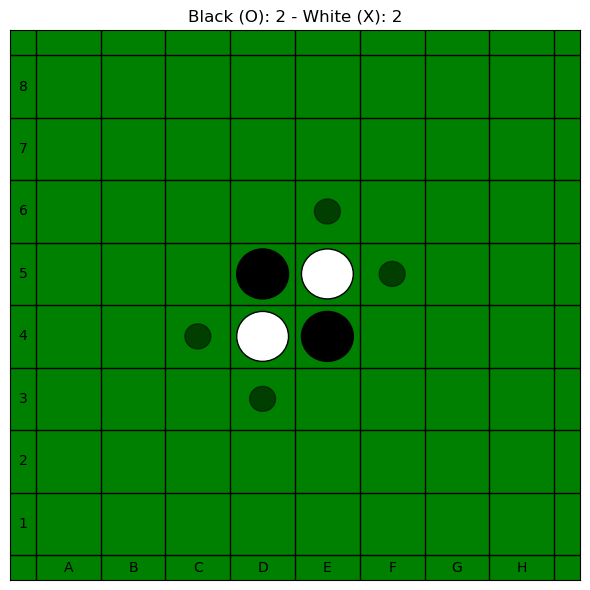

In [2]:
# Create a game instance
game = OthelloGame()
# Set up the game
game.display(highlight_legal=True, show_history=True)

## Minimax (Negamax) Algorithm

In adversarial games like Othello, we need decision-making algorithms that can anticipate an opponent's best moves. The Minimax algorithm is perfect for this purpose, allowing our AI to look ahead and plan strategically.

### What is Minimax?

Minimax is a decision rule used for minimizing the possible loss in a worst-case scenario. In the context of two-player games:

- The **maximizing player** (our AI) aims to get the highest possible score
- The **minimizing player** (opponent) aims to get the lowest possible score (or prevent our AI from scoring)
- The algorithm recursively evaluates all possible future game states up to a certain depth

### How Minimax Works

1. **Game Tree Construction**: Build a tree of possible future game states
2. **Recursive Evaluation**: Starting from leaf nodes (terminal states or depth limit)
3. **Alternating Minimizing and Maximizing**: 
   - At maximizing player's turn, choose move with highest value
   - At minimizing player's turn, choose move with lowest value
4. **Backpropagation**: Values propagate upward from leaves to the root

### Implementation for Othello

For our Othello AI, we'll implement the Negamax (a variant of Minimax) algorithm, allowing us to:

1. Evaluate potential moves by looking several steps ahead
2. Consider the opponent's best responses
3. Select moves that maximize our long-term advantage

Let's start by writing an `evaluate` function that gives a static evaluation of an Othello grid. The score will be positive for the maximizing player (typically Black) and negative for the other.

The most straightforward evaluation metric is simply counting pieces, but this is often misleading in Othello since having more pieces early in the game can actually be disadvantageous. However, this metric is a good starting point. 

In [ ]:
def evaluate_simple_count(game, player):
    """
    Simple evaluation function that counts pieces.
    
    Args:
        game: Current game state
        player: Player to evaluate for (BLACK or WHITE)
    
    Returns:
        Score (positive is good for player)
    """
    # Count pieces for the player and opponent
    score = np.sum(game.board == player) - np.sum(game.board == -player)
    return score

Also, certain positions on the board are strategically more valuable than others:
- Corners are most valuable as they cannot be flipped
- Edges are valuable as they can only be flipped from limidted directions
- Positions adjacent to corners are risky as they can give the opponent access to corners

In [47]:
def evaluate_position(game, player):
    """
    Evaluation based on piece positions on the board.
    
    Args:
        game: Current game state
        player: Player to evaluate for
    
    Returns:
        Weighted score considering position value
    """
    # Position weights - higher values for better positions
    position_weights = np.array([
        [10, -5,  3,  3,  3,  3, -5, 10],
        [-5, -5, -1, -1, -1, -1, -5, -5],
        [3, -1,  1,  1,  1,  1, -1,  3],
        [3, -1,  1,  1,  1,  1, -1,  3],
        [3, -1,  1,  1,  1,  1, -1,  3],
        [3, -1,  1,  1,  1,  1, -1,  3],
        [-5, -5, -1, -1, -1, -1, -5, -5],
        [10, -5,  3,  3,  3,  3, -5, 10]
    ])
    
    board_array = game.board.reshape(8, 8)
    
    # Calculate weighted sum for player and opponent
    player_score = np.sum(position_weights[board_array == player])
    opponent_score = np.sum(position_weights[board_array == -player])
    
    return player_score - opponent_score

The number of legal moves available to each player is also a good metric, as it indicates how many options they have for their next turn. Having more options is generally better.

In [42]:
def evaluate_mobility(game, player):
    """
    Evaluation based on player mobility (number of legal moves).
    
    Args:
        game: Current game state
        player: Player to evaluate for
    
    Returns:
        Mobility score
    """
    # Save current player state
    original_player = game.current_player
    
    # Set current player temporarily to calculate legal moves
    game.current_player = player
    player_moves = len(game.legal_moves()) - (game.PASS_MOVE in game.legal_moves())
    
    game.current_player = -player
    opponent_moves = len(game.legal_moves()) - (game.PASS_MOVE in game.legal_moves())
    
    # Restore original player
    game.current_player = original_player
    
    return player_moves - opponent_moves

For obtaining a more accurate evaluation, we can combine these metrics into a single score. The final evaluation function will be a weighted sum of the components. Depending on the game state, we can adjust the weights to emphasize certain aspects of the game. For example, in the early game, we might want to focus more on mobility, while in the late game, we might want to focus more on piece count.

In [45]:
def evaluate(game, player, phase='midgame'):
    """
    Combined evaluation function that adjusts strategy based on game phase.
    
    Args:
        game: Current game state
        player: Player to evaluate for
        phase: Game phase ('early', 'midgame', or 'endgame')
    
    Returns:
        Weighted evaluation score
    """
    # Count total pieces to determine game phase if not specified
    if phase == 'auto':
        total_pieces = np.sum(game.board != 0)
        if total_pieces < 20:
            phase = 'early'
        elif total_pieces < 50:
            phase = 'midgame'
        else:
            phase = 'endgame'
    
    # Piece count evaluation
    piece_count = evaluate_simple_count(game, player)
    
    # Positional evaluation
    position_score = evaluate_position(game, player)
    
    # Mobility evaluation
    mobility_score = evaluate_mobility(game, player)
    
    # Corner control (specifically tracked)
    corners = [0, 7, 56, 63]  # Corner positions
    corner_score = 0
    for corner in corners:
        if game.board[corner] == player:
            corner_score += 25
        elif game.board[corner] == -player:
            corner_score -= 25
    
    # Weight components based on game phase
    if phase == 'early':
        # Early game: prioritize position and mobility
        return 10 * position_score + 50 * mobility_score + 100 * corner_score + piece_count
    
    elif phase == 'midgame':
        # Mid game: balanced approach
        return 15 * position_score + 30 * mobility_score + 100 * corner_score + 10 * piece_count
    
    else:  # endgame
        # End game: prioritize piece count
        return 5 * position_score + 10 * mobility_score + 100 * corner_score + 50 * piece_count

Let's test the evaluation function to see how it performs on a randomly generated game state. 

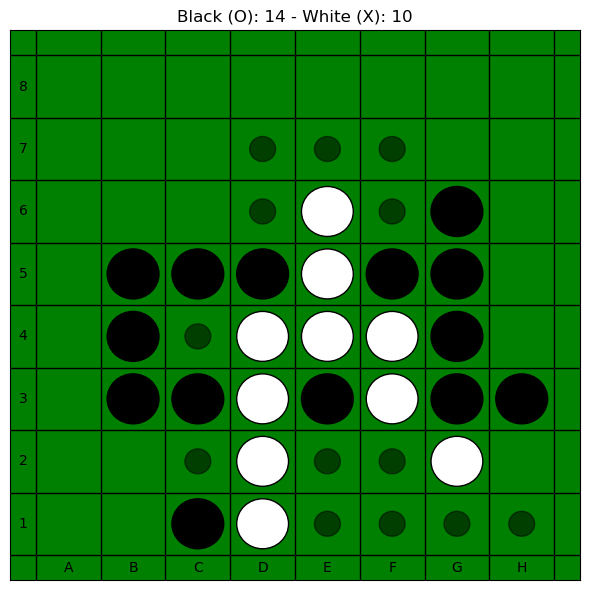

Score for White: 80
Score for Black: -80


In [69]:
# Create a fresh game instance
game = OthelloGame()

# Play 20 random moves to reach a midgame state
for _ in range(20):
    if game.is_terminal():
        break
    move = random_player(game)
    game.make_move(move)

# Display the current board
game.display(highlight_legal=True)

# Evaluate and display the results
print(f"Score for White: {evaluate(game, game.WHITE)}")
print(f"Score for Black: {evaluate(game, game.BLACK)}")

#### Negamax search

A convenient variant of Minimax is Negamax, which leverages the observation that the minimizing player's utility can be interpreted as the negative utility of the maximizing player. This simplifies the code by letting one function handle both players, flipping the sign of the evaluation at each recursive layer.

In the context of Othello:
- We decide on a maximum search depth (e.g., 4).
- If the maximum depth is reached or the position is terminal, we evaluate the board using our heuristic.
- Otherwise, we generate all legal moves and recursively apply Negamax, choosing the move that yields the best outcome for the current player.

In [ ]:
def negamax(game, depth, eval_func):
    """
    Negamax search
    
    Args:
        game: An instance of OthelloGame representing the current state.
        depth: Maximum search depth.
        eval_func: Evaluation function to use at leaf nodes.
    
    Returns:
        (best_move, best_value):
            best_move: The move (board index or PASS_MOVE) leading to the best outcome.
            best_value: The negamax value from the current player's perspective.
    """
    
    # If we're at the maximum depth or the game is over, return the evaluation
    if depth == 0 or game.is_terminal():
        return None, eval_func(game, game.current_player)
    
    legal = game.legal_moves()
    
    # If there's only a pass move, check if that results in an end or not
    if len(legal) == 1 and legal[0] == game.PASS_MOVE:
        # Make a pass move
        new_game = OthelloGame()
        new_game.board = np.copy(game.board)
        new_game.current_player = game.current_player
        new_game.history = list(game.history)
        new_game.make_move(OthelloGame.PASS_MOVE)
        
        # Recurse at reduced depth
        _, value = negamax(new_game, depth - 1, eval_func)
        return OthelloGame.PASS_MOVE, -value
    
    best_value = -float('inf')
    best_move = None
    
    for move in legal:
        # Copy the game state to simulate the move
        new_game = OthelloGame()
        new_game.board = np.copy(game.board)
        new_game.current_player = game.current_player
        new_game.history = list(game.history)
        
        new_game.make_move(move)
        
        # Negamax recursion: flip the sign for the opponent
        _, value = negamax(new_game, depth - 1, eval_func)
        
        # Negate the value from the opponent's perspective
        value = -value
        
        # Track the best value
        if value > best_value:
            best_value = value
            best_move = move
    
    return best_move, best_value
